In [1]:
!pip install tensorflow
!pip install tensorflow_datasets
!pip install transformers
!pip install tf-keras
!pip install shap
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 179.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizerFast
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

2025-06-26 23:58:26.658986: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-26 23:58:26.664424: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-26 23:58:26.677576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750982306.699081    4741 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750982306.705306    4741 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750982306.722397    4741 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
# Load the saved model
model_path = './sentiment_model_distilbert'
model = TFDistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Load test dataset (same preprocessing as training)
(_, ds_test), ds_info = tfds.load(
    'imdb_reviews',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

2025-06-26 23:58:31.874776: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at ./sentiment_model_distilbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [4]:
# Tokenization functions (same as training script)
def encode(text, label):
    tokens = tokenizer(
        text.numpy().decode('utf-8'),
        truncation=True,
        padding='max_length',
        max_length=256
    )
    return tokens['input_ids'], tokens['attention_mask'], label

def tf_encode(text, label):
    input_ids, attention_mask, label = tf.py_function(
        encode, [text, label], [tf.int32, tf.int32, tf.int64]
    )
    input_ids.set_shape([256])
    attention_mask.set_shape([256])
    label.set_shape([])
    return {"input_ids": input_ids, "attention_mask": attention_mask}, label

In [5]:
# Prepare test dataset
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16
ds_test_processed = ds_test.map(tf_encode, num_parallel_calls=AUTOTUNE)
ds_test_processed = ds_test_processed.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Compile model for evaluation
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [6]:
# 1. Basic model evaluation
test_loss, test_accuracy = model.evaluate(ds_test_processed, verbose=1)
print(f"\nBasic Evaluation Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# 2. Get predictions and true labels for detailed metrics
print("\nGenerating predictions for detailed metrics...")
y_true = []
y_pred_logits = []

for batch_x, batch_y in ds_test_processed:
    predictions = model(batch_x, training=False)
    y_pred_logits.extend(predictions.logits.numpy())
    y_true.extend(batch_y.numpy())

y_true = np.array(y_true)
y_pred_logits = np.array(y_pred_logits)

# Convert logits to probabilities and predictions
y_pred_proba = tf.nn.softmax(y_pred_logits, axis=1).numpy()
y_pred = np.argmax(y_pred_logits, axis=1)

# 3. Classification Report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

# 4. Confusion Matrix
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Calculate additional metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"\nDetailed Metrics:")
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")

# 5. ROC-AUC Score
roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1])
print(f"ROC-AUC Score: {roc_auc:.4f}")

2025-06-26 23:58:38.826249: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


1563/1563 [==============================] - 3506s 2s/step - loss: 0.2432 - accuracy: 0.9079

Basic Evaluation Results:
Test Loss: 0.2432
Test Accuracy: 0.9079

Generating predictions for detailed metrics...

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative       0.92      0.89      0.91     12500
    Positive       0.89      0.92      0.91     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000


CONFUSION MATRIX
[[11137  1363]
 [  940 11560]]

Detailed Metrics:
True Positives: 11560
True Negatives: 11137
False Positives: 1363
False Negatives: 940
Precision: 0.8945
Recall (Sensitivity): 0.9248
Specificity: 0.8910
F1-Score: 0.9094
ROC-AUC Score: 0.9694


2025-06-27 02:07:35.092414: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


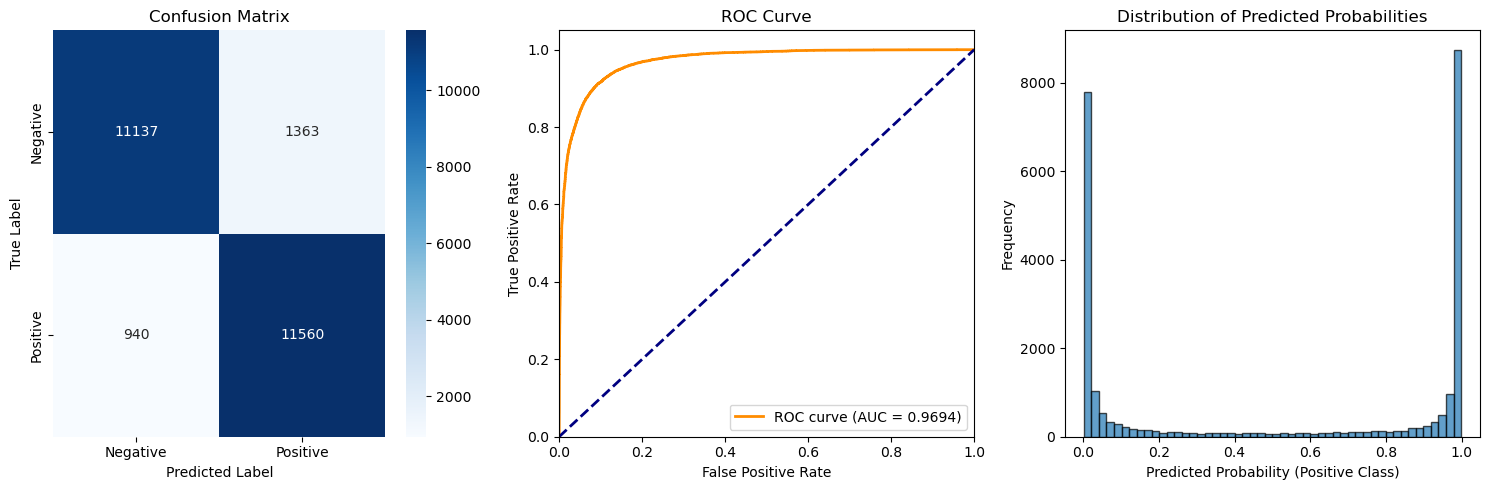


SAMPLE PREDICTIONS WITH CONFIDENCE

Sample 1:
Text: The fact that a film is on DVD doesn't guarantee that its quality is very good. The fact that a film's quality is threadbare doesn't mean you shouldn't buy it. This review actually applies to 2 films ...
True Label: Negative
Predicted Label: Positive
Confidence: 0.5277
Correct: ✗
--------------------------------------------------

Sample 2:
Text: When I fist watched the movie, I said to myself, "so a film can be made like this." Wong Kar Wai's gorgeous poetic love story captured me throughout and even after the film. I must admit this is one o...
True Label: Positive
Predicted Label: Positive
Confidence: 0.6643
Correct: ✓
--------------------------------------------------

Sample 3:
Text: I caught this movie a few years ago one night, and it was one of the funniest movies I have ever seen. However, since it is supposed to be an action movie, I cannot give it more stars since the humor ...
True Label: Negative
Predicted Label: Positiv

In [7]:
# 6. Visualizations
plt.figure(figsize=(15, 5))

# Confusion Matrix Heatmap
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Prediction Distribution
plt.subplot(1, 3, 3)
plt.hist(y_pred_proba[:, 1], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Predicted Probability (Positive Class)')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')

plt.tight_layout()
plt.savefig('model_evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# 7. Sample predictions with confidence
print("\n" + "="*50)
print("SAMPLE PREDICTIONS WITH CONFIDENCE")
print("="*50)

# Get some sample texts and their predictions
sample_indices = np.random.choice(len(y_true), 5, replace=False)
sample_texts = []

# We need to get the original texts, so let's process a few samples
count = 0
for text, label in ds_test.take(len(y_true)):
    if count in sample_indices:
        sample_texts.append((text.numpy().decode('utf-8'), label.numpy()))
    count += 1
    if len(sample_texts) == 5:
        break

for i, (text, true_label) in enumerate(sample_texts):
    idx = sample_indices[i]
    pred_label = y_pred[idx]
    confidence = max(y_pred_proba[idx])
    
    print(f"\nSample {i+1}:")
    print(f"Text: {text[:200]}...")
    print(f"True Label: {'Positive' if true_label == 1 else 'Negative'}")
    print(f"Predicted Label: {'Positive' if pred_label == 1 else 'Negative'}")
    print(f"Confidence: {confidence:.4f}")
    print(f"Correct: {'✓' if pred_label == true_label else '✗'}")
    print("-" * 50)

In [8]:
# 8. Summary
print("\n" + "="*50)
print("EVALUATION SUMMARY")
print("="*50)
print(f"Overall Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Total Test Samples: {len(y_true)}")


EVALUATION SUMMARY
Overall Accuracy: 0.9079
Precision: 0.8945
Recall: 0.9248
F1-Score: 0.9094
ROC-AUC: 0.9694
Total Test Samples: 25000


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.



SHAP GLOBAL EXPLANATION
Preparing sample data for SHAP analysis...
Collected 200 samples for SHAP analysis
Positive samples: 90
Negative samples: 110

Performing manual feature importance analysis...
Analyzing word importance for POSITIVE sentiment...
Analyzing word importance for NEGATIVE sentiment...

TOP 10 MOST INFLUENTIAL WORDS - TEXTUAL RESULTS

🔹 TOP 10 WORDS INFLUENCING POSITIVE SENTIMENT:
----------------------------------------
1. 'often' - Importance: 0.3003
2. 'pathetic' - Importance: 0.2581
3. 'afoot' - Importance: 0.2460
4. 'camera' - Importance: 0.2359
5. 'criticizing' - Importance: 0.2346
6. 'double-entendres' - Importance: 0.2287
7. 'globalpublicmedia.com' - Importance: 0.2199
8. 'video' - Importance: 0.2196
9. 'lost' - Importance: 0.2150
10. 'lead' - Importance: 0.2098

🔸 TOP 10 WORDS INFLUENCING NEGATIVE SENTIMENT:
----------------------------------------
1. 'surprising' - Importance: 0.2089
2. 'release' - Importance: 0.1244
3. 'sesame' - Importance: 0.1144
4. 'ever

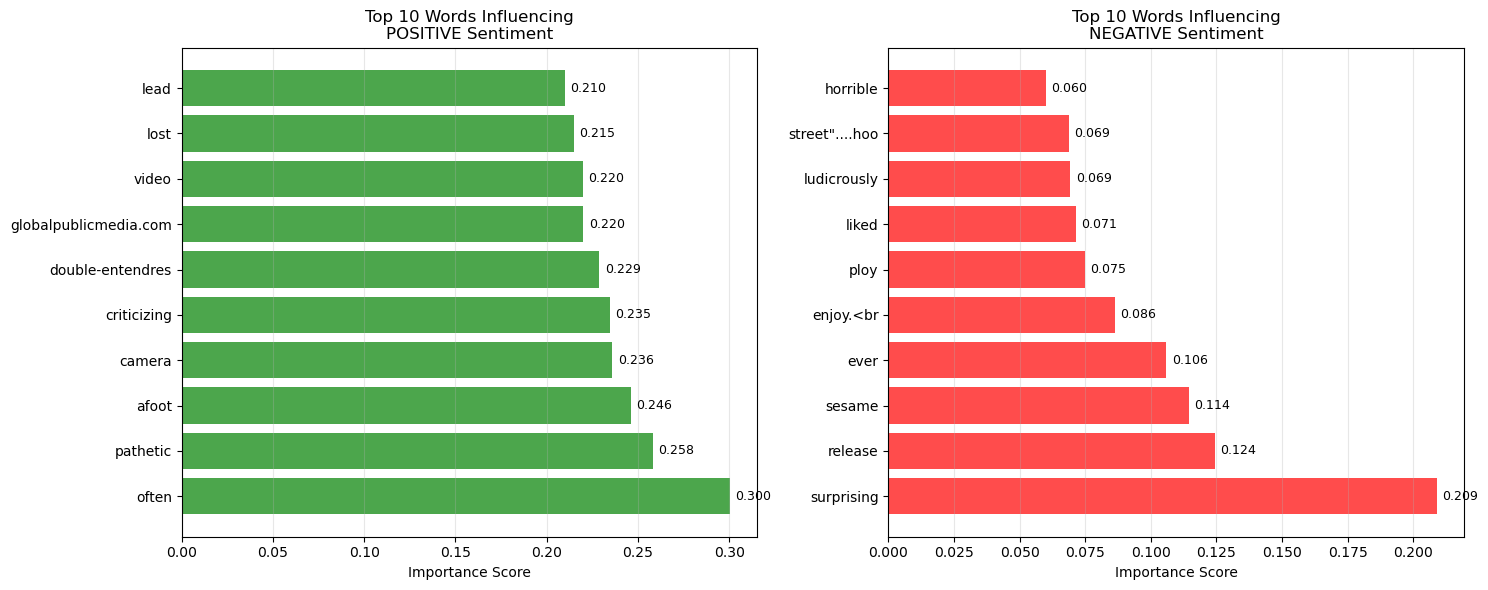

In [9]:
# 9. SHAP Global Explanation
print("\n" + "="*50)
print("SHAP GLOBAL EXPLANATION")
print("="*50)

# Create a prediction function that works with SHAP's text explainer
def predict_proba(texts):
    """Prediction function for SHAP that handles text input"""
    if isinstance(texts, str):
        texts = [texts]
    elif isinstance(texts, np.ndarray):
        texts = texts.tolist()
    
    predictions = []
    for text in texts:
        # Handle potential encoding issues
        if isinstance(text, bytes):
            text = text.decode('utf-8')
        elif not isinstance(text, str):
            text = str(text)
            
        # Tokenize the text
        tokens = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=256,
            return_tensors='tf'
        )
        
        # Get model prediction
        logits = model(tokens, training=False).logits
        probabilities = tf.nn.softmax(logits, axis=1).numpy()
        predictions.append(probabilities[0])
    
    return np.array(predictions)

# Prepare sample data for SHAP analysis
print("Preparing sample data for SHAP analysis...")
sample_texts_for_shap = []
sample_labels_for_shap = []

# Collect samples for SHAP analysis
count = 0
target_samples = 200  # Reduced for faster computation !!!!!!!!!!
for text, label in ds_test.take(500):
    if count >= target_samples:
        break
    text_str = text.numpy().decode('utf-8')
    # Clean text and ensure it's not too long
    text_str = text_str.replace('\n', ' ').replace('\r', ' ')
    if len(text_str.split()) > 10:  # Only use texts with reasonable length
        sample_texts_for_shap.append(text_str)
        sample_labels_for_shap.append(label.numpy())
        count += 1

print(f"Collected {len(sample_texts_for_shap)} samples for SHAP analysis")

# Separate positive and negative samples
positive_texts = [text for text, label in zip(sample_texts_for_shap, sample_labels_for_shap) if label == 1]
negative_texts = [text for text, label in zip(sample_texts_for_shap, sample_labels_for_shap) if label == 0]

print(f"Positive samples: {len(positive_texts)}")
print(f"Negative samples: {len(negative_texts)}")

# Alternative approach: Manual feature importance analysis
print("\nPerforming manual feature importance analysis...")

def analyze_word_importance(texts, true_labels, model, tokenizer, sentiment_class):
    """Analyze word importance by measuring prediction change when words are removed"""
    word_importance_scores = {}
    
    for text in texts[:10]:  # Analyze first 10 texts to save time
        words = text.split()
        if len(words) < 3:
            continue
            
        # Get baseline prediction
        baseline_pred = predict_proba([text])[0]
        baseline_score = baseline_pred[sentiment_class]
        
        # Test each word's importance
        for i, word in enumerate(words):
            if len(word) <= 2:  # Skip short words
                continue
                
            # Create text without this word
            modified_words = words[:i] + words[i+1:]
            modified_text = ' '.join(modified_words)
            
            if len(modified_text.strip()) == 0:
                continue
                
            # Get prediction without this word
            modified_pred = predict_proba([modified_text])[0]
            modified_score = modified_pred[sentiment_class]
            
            # Calculate importance as difference in prediction confidence
            importance = abs(baseline_score - modified_score)
            
            word_lower = word.lower().strip('.,!?":;()[]{}')
            if word_lower not in word_importance_scores:
                word_importance_scores[word_lower] = []
            word_importance_scores[word_lower].append(importance)
    
    # Calculate average importance for each word
    word_avg_importance = {}
    for word, scores in word_importance_scores.items():
        if len(scores) > 0 and len(word) > 2:
            word_avg_importance[word] = np.mean(scores)
    
    # Return top words
    sorted_words = sorted(word_avg_importance.items(), key=lambda x: x[1], reverse=True)
    return sorted_words[:10]

# Analyze word importance for positive sentiment
print("Analyzing word importance for POSITIVE sentiment...")
if len(positive_texts) > 0:
    top_positive_words = analyze_word_importance(positive_texts, [1]*len(positive_texts), 
                                               model, tokenizer, sentiment_class=1)
else:
    top_positive_words = []

# Analyze word importance for negative sentiment  
print("Analyzing word importance for NEGATIVE sentiment...")
if len(negative_texts) > 0:
    top_negative_words = analyze_word_importance(negative_texts, [0]*len(negative_texts),
                                               model, tokenizer, sentiment_class=0)
else:
    top_negative_words = []

# Display results textually
print("\n" + "="*50)
print("TOP 10 MOST INFLUENTIAL WORDS - TEXTUAL RESULTS")
print("="*50)

print("\n🔹 TOP 10 WORDS INFLUENCING POSITIVE SENTIMENT:")
print("-" * 40)
if top_positive_words:
    for i, (word, importance) in enumerate(top_positive_words, 1):
        print(f"{i}. '{word}' - Importance: {importance:.4f}")
else:
    print("No positive words found in analysis")

print("\n🔸 TOP 10 WORDS INFLUENCING NEGATIVE SENTIMENT:")
print("-" * 40)
if top_negative_words:
    for i, (word, importance) in enumerate(top_negative_words, 1):
        print(f"{i}. '{word}' - Importance: {importance:.4f}")
else:
    print("No negative words found in analysis")

# Create visualizations only if we have data
if top_positive_words or top_negative_words:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot for positive words
    if top_positive_words:
        words_pos = [item[0] for item in top_positive_words]
        importance_pos = [item[1] for item in top_positive_words]
        
        axes[0].barh(range(len(words_pos)), importance_pos, color='green', alpha=0.7)
        axes[0].set_yticks(range(len(words_pos)))
        axes[0].set_yticklabels(words_pos)
        axes[0].set_xlabel('Importance Score')
        axes[0].set_title('Top 10 Words Influencing\nPOSITIVE Sentiment')
        axes[0].grid(axis='x', alpha=0.3)
        
        # Add value labels on bars
        for i, v in enumerate(importance_pos):
            axes[0].text(v + max(importance_pos)*0.01, i, f'{v:.3f}', va='center', fontsize=9)
    else:
        axes[0].text(0.5, 0.5, 'No positive words found', ha='center', va='center', transform=axes[0].transAxes)
        axes[0].set_title('Top 10 Words Influencing\nPOSITIVE Sentiment')
    
    # Plot for negative words
    if top_negative_words:
        words_neg = [item[0] for item in top_negative_words]
        importance_neg = [item[1] for item in top_negative_words]
        
        axes[1].barh(range(len(words_neg)), importance_neg, color='red', alpha=0.7)
        axes[1].set_yticks(range(len(words_neg)))
        axes[1].set_yticklabels(words_neg)
        axes[1].set_xlabel('Importance Score')
        axes[1].set_title('Top 10 Words Influencing\nNEGATIVE Sentiment')
        axes[1].grid(axis='x', alpha=0.3)
        
        # Add value labels on bars
        for i, v in enumerate(importance_neg):
            axes[1].text(v + max(importance_neg)*0.01, i, f'{v:.3f}', va='center', fontsize=9)
    else:
        axes[1].text(0.5, 0.5, 'No negative words found', ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Top 10 Words Influencing\nNEGATIVE Sentiment')
    
    plt.tight_layout()
    plt.savefig('word_importance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


SHAP LOCAL EXPLANATION - INDIVIDUAL WORD INFLUENCES
Selected 5 observations for individual analysis

Analyzing individual observations...
Processing observation 1/5...
Processing observation 2/5...
Processing observation 3/5...
Processing observation 4/5...
Processing observation 5/5...

INDIVIDUAL WORD INFLUENCES - TEXTUAL RESULTS

📄 OBSERVATION 1
Text (first 500 chars): The Ghost Walks is a nifty little mystery with a great twist, snappy dialog, and best of all a pansy played to the twittery hilt by character actor Johnny Arthur which never demeans or denigrates his character. Mr. Arthur is great in his role of Homer Erskine bringing great comic relief as the secretary of the Broadway producer Herman Wood, played by another great character actor Richard Carle.<br /><br />They play off of each other superbly.<br /><br />Although the acceptable words of the time ...
True Label: Positive
Predicted: Positive
Confidence: 0.9980
Correct: ✓

🔍 TOP INFLUENTIAL WORDS:
-----------------------

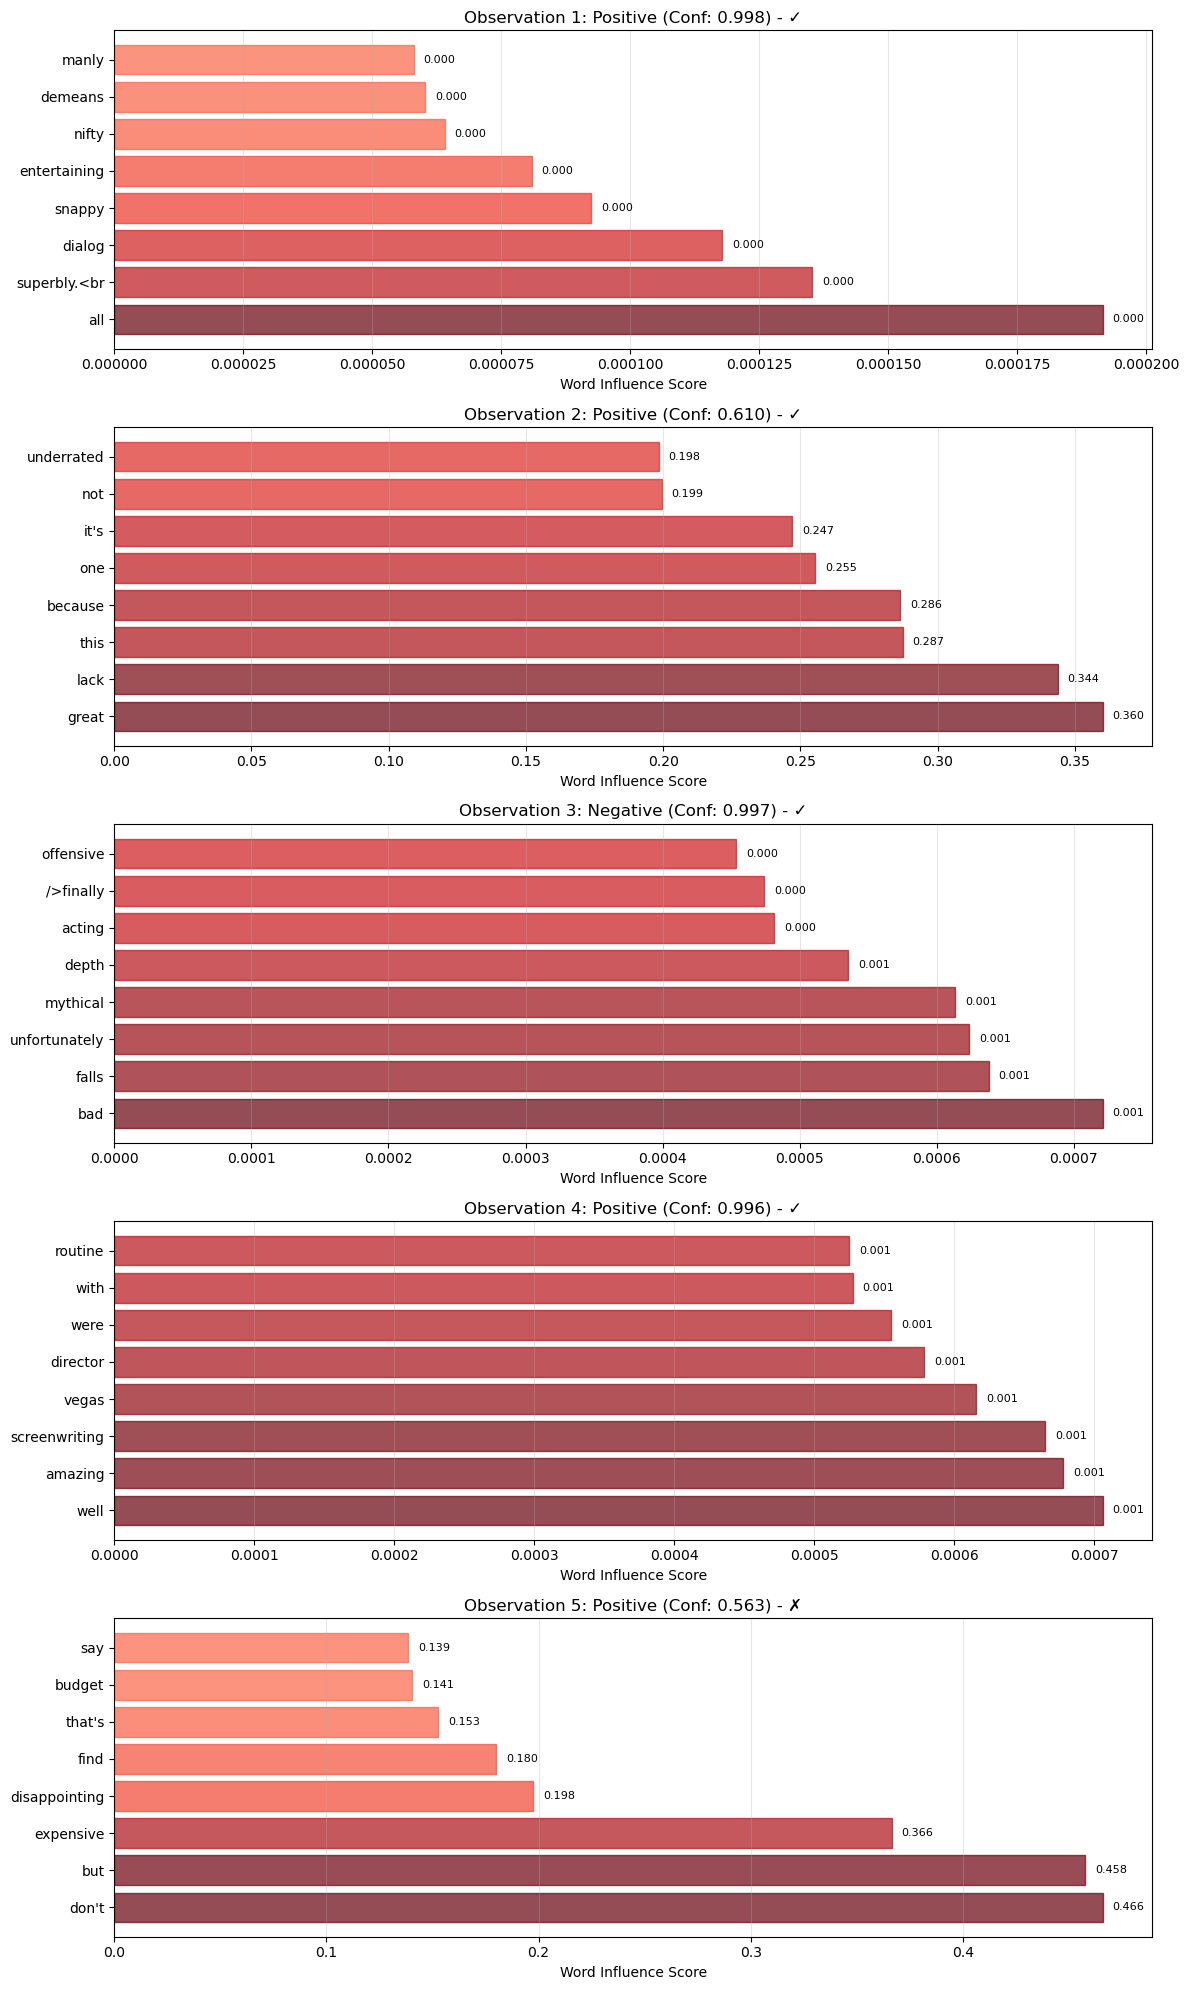

In [12]:
# SHAP Local Explanation - Individual Word Influences
print("\n" + "="*50)
print("SHAP LOCAL EXPLANATION - INDIVIDUAL WORD INFLUENCES")
print("="*50)

print(f"Selected {len(selected_texts)} observations for individual analysis")

def get_word_level_shap_explanation(text, model, tokenizer):
    """Get SHAP explanation at word level for individual text"""
    
    # Get model prediction for the original text using the existing predict_proba function
    baseline_pred = predict_proba([text])[0]
    predicted_class = np.argmax(baseline_pred)
    confidence = max(baseline_pred)
    
    # Split text into words
    words = text.split()
    word_importance = {}
    
    # Test each word's importance by removal
    for i, word in enumerate(words):
        if len(word) <= 2:  # Skip very short words
            continue
            
        # Create text without this word
        modified_words = words[:i] + words[i+1:]
        modified_text = ' '.join(modified_words)
        
        if len(modified_text.strip()) == 0:
            continue
            
        # Get prediction for modified text using the existing predict_proba function
        try:
            modified_pred = predict_proba([modified_text])[0]
            
            # Calculate importance as change in prediction for the predicted class
            importance = abs(baseline_pred[predicted_class] - modified_pred[predicted_class])
            
            word_clean = word.lower().strip('.,!?":;()[]{}')
            if word_clean: # Ensure word is not empty after stripping
                word_importance[word_clean] = importance
            
        except Exception as e:
            # It's good practice to know if predictions fail
            print(f"Could not get prediction for modified text: {e}")
            continue
    
    # Sort words by importance
    sorted_word_importance = sorted(word_importance.items(), key=lambda x: x[1], reverse=True)
    
    return {
        'text': text,
        'predicted_class': predicted_class,
        'confidence': confidence,
        'word_importance': sorted_word_importance[:10],  # Top 10 words
        'baseline_pred': baseline_pred
    }

# Analyze each selected observation
print("\nAnalyzing individual observations...")
local_explanations = []

for i, (text, true_label) in enumerate(zip(selected_texts, selected_labels)):
    print(f"Processing observation {i+1}/5...")
    explanation = get_word_level_shap_explanation(text, model, tokenizer)
    explanation['true_label'] = true_label
    explanation['observation_id'] = i+1
    local_explanations.append(explanation)

# Display textual results
print("\n" + "="*50)
print("INDIVIDUAL WORD INFLUENCES - TEXTUAL RESULTS")
print("="*50)

for exp in local_explanations:
    print(f"\n📄 OBSERVATION {exp['observation_id']}")
    print("=" * 60)
    print(f"Text (first 500 chars): {exp['text'][:500]}...")
    print(f"True Label: {'Positive' if exp['true_label'] == 1 else 'Negative'}")
    print(f"Predicted: {'Positive' if exp['predicted_class'] == 1 else 'Negative'}")
    print(f"Confidence: {exp['confidence']:.4f}")
    print(f"Correct: {'✓' if exp['predicted_class'] == exp['true_label'] else '✗'}")
    
    print(f"\n🔍 TOP INFLUENTIAL WORDS:")
    print("-" * 40)
    for j, (word, importance) in enumerate(exp['word_importance'][:5], 1):
        print(f"{j}. '{word}' - Influence: {importance:.4f}")
    print()

# Create waterfall plots for each observation
print("Creating waterfall plots for individual explanations...")

fig, axes = plt.subplots(5, 1, figsize=(12, 20))

for i, exp in enumerate(local_explanations):
    ax = axes[i]
    
    if len(exp['word_importance']) > 0:
        # Get top 8 words for visualization
        top_words = exp['word_importance'][:8]
        words = [item[0] for item in top_words]
        influences = [item[1] for item in top_words]
        
        # Create horizontal bar plot (waterfall style)
        y_positions = np.arange(len(words))
        bars = ax.barh(y_positions, influences, color='steelblue', alpha=0.7)
        
        # Customize plot
        ax.set_yticks(y_positions)
        ax.set_yticklabels(words)
        ax.set_xlabel('Word Influence Score')
        ax.set_title(f'Observation {i+1}: {"Positive" if exp["predicted_class"] == 1 else "Negative"} '
                    f'(Conf: {exp["confidence"]:.3f}) - {"✓" if exp["predicted_class"] == exp["true_label"] else "✗"}')
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels on bars
        for j, (bar, influence) in enumerate(zip(bars, influences)):
            ax.text(influence + max(influences)*0.01, j, f'{influence:.3f}', 
                   va='center', fontsize=8)
        
        # Color bars based on influence strength
        max_influence = max(influences) if influences else 1
        for bar, influence in zip(bars, influences):
            intensity = influence / max_influence
            bar.set_color(plt.cm.Reds(0.3 + 0.7 * intensity))
    
    else:
        ax.text(0.5, 0.5, 'No significant word influences found', 
               ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'Observation {i+1}: No influences detected')

plt.tight_layout()
plt.savefig('shap_local_word_influences_waterfall.png', dpi=300, bbox_inches='tight')
plt.show()